# Training
This notebook trains the model with 3 fold cross validation.

In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 11:44:53] [setup] RAM Tracking...
[codecarbon INFO @ 11:44:53] [setup] GPU Tracking...
[codecarbon INFO @ 11:44:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:44:54] [setup] CPU Tracking...
[codecarbon WARNING @ 11:44:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:44:56] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 11:44:56] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 11:44:56] >>> Tracker's metadata:
[codecarbon INFO @ 11:44:56]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 11:44:56]   Python version: 3.11.3
[codecarbon INFO @ 11:44:56]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 11:44:56]   Available RAM : 256.000 GB
[codecarbon INFO @ 11:44:56]   CPU count: 24
[codecarbon INFO @ 11:44:56]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

# Imports and setup

In [3]:
import sys
# Need this to load the packages correct in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)

dlrpvayq52ul


In [8]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_rest"
file_name = "high_vs_rest_top_50_hp_repos_balanced_github.csv"
priority_df = pd.read_csv(f"{path_to_files}/{file_name}")
priority_df

,label,text
0,1,establish how much time were spending on jenki...
1,0,can not create an api without endpoint descrip...
2,1,duplicate pod cidr assignments in we spun up a...
3,1,rbac migration followup revisit forbidden mess...
4,1,switch to use apiuser api calls because of rec...
...,...,...
106975,0,send to is a bit hidden this issue was origina...
106976,0,could mapnik render landuseorchard i would lov...
106977,0,fnx ⁃ search checklist ongoing feature level c...
106978,1,cannot write test methods when importing a mod...


In [12]:
# Check if NaN
priority_df.isna().any()

label    False
text     False
dtype: bool

In [13]:
priority_df

,label,text
0,1,establish how much time were spending on jenki...
1,0,can not create an api without endpoint descrip...
2,1,duplicate pod cidr assignments in we spun up a...
3,1,rbac migration followup revisit forbidden mess...
4,1,switch to use apiuser api calls because of rec...
...,...,...
106975,0,send to is a bit hidden this issue was origina...
106976,0,could mapnik render landuseorchard i would lov...
106977,0,fnx ⁃ search checklist ongoing feature level c...
106978,1,cannot write test methods when importing a mod...


In [14]:
priority_df["label"].value_counts()

label
1    53490
0    53490
Name: count, dtype: int64

In [15]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [16]:
df = train_hp_df
df

,label,text
21066,0,muon analysis workflow improvements umbrella i...
79264,0,vulnerability report failure to invalidate ses...
50925,0,visibility of replacereplaceall inconsistency ...
49751,0,is this a feature request what happened cat ku...
41419,1,emails sent to study participants must use stu...
...,...,...
76968,1,bvm crashes when assigning function pointer wi...
96686,1,rbac migration followup test fixes confirm cha...
17077,0,observatorys debugger cant scroll source code ...
24680,1,saml sso breaks when enabling assertion encryp...


In [17]:
df.reset_index(inplace = True)
df = df.drop('index', axis=1)
df

,label,text
0,0,muon analysis workflow improvements umbrella i...
1,0,vulnerability report failure to invalidate ses...
2,0,visibility of replacereplaceall inconsistency ...
3,0,is this a feature request what happened cat ku...
4,1,emails sent to study participants must use stu...
...,...,...
90928,1,bvm crashes when assigning function pointer wi...
90929,1,rbac migration followup test fixes confirm cha...
90930,0,observatorys debugger cant scroll source code ...
90931,1,saml sso breaks when enabling assertion encryp...


In [18]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [19]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15167
       0        15144
1      0        15169
       1        15142
2      0        15170
       1        15141
Name: count, dtype: int64

In [20]:
df

,label,text,kfold
0,0,muon analysis workflow improvements umbrella i...,0
1,0,vulnerability report failure to invalidate ses...,2
2,0,visibility of replacereplaceall inconsistency ...,2
3,0,is this a feature request what happened cat ku...,1
4,1,emails sent to study participants must use stu...,2
...,...,...,...
90928,1,bvm crashes when assigning function pointer wi...,0
90929,1,rbac migration followup test fixes confirm cha...,1
90930,0,observatorys debugger cant scroll source code ...,0
90931,1,saml sso breaks when enabling assertion encryp...,1


In [21]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [22]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [23]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [24]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [25]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [26]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [28]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [30]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [31]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [32]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1895/1895 [05:16<00:00,  5.99it/s, Epoch=1, LR=1.52e-6, Valid_Loss=0.52] 


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7176    0.7548    0.7357     15144
          HP     0.7418    0.7035    0.7221     15167

    accuracy                         0.7291     30311
   macro avg     0.7297    0.7291    0.7289     30311
weighted avg     0.7297    0.7291    0.7289     30311

Accuracy = 0.7291
F1_score = 0.7221
Validation Loss Improved (inf ---> 0.5204313608366797)
Model Saved



100%|██████████| 1895/1895 [05:15<00:00,  6.00it/s, Epoch=2, LR=8.05e-6, Valid_Loss=0.504]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7177    0.7971    0.7553     15144
          HP     0.7723    0.6870    0.7271     15167

    accuracy                         0.7420     30311
   macro avg     0.7450    0.7420    0.7412     30311
weighted avg     0.7450    0.7420    0.7412     30311

Accuracy = 0.742
F1_score = 0.7271
Validation Loss Improved (0.5204313608366797 ---> 0.5041229610909397)
Model Saved



100%|██████████| 1895/1895 [05:15<00:00,  6.01it/s, Epoch=3, LR=4.96e-6, Valid_Loss=0.501]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7355    0.7914    0.7625     15144
          HP     0.7746    0.7159    0.7441     15167

    accuracy                         0.7536     30311
   macro avg     0.7551    0.7536    0.7533     30311
weighted avg     0.7551    0.7536    0.7533     30311

Accuracy = 0.7536
F1_score = 0.7441
Validation Loss Improved (0.5041229610909397 ---> 0.50137801634782)
Model Saved

Training complete in 2h 1m 26s
Best Loss: 0.5014


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▃▁
Valid Accuracy,▁▅█
Valid F1_score,▁▃█
Valid Loss,█▂▁
Best Loss,0.50138
Train Loss,0.46302
Valid Accuracy,0.7536
Valid F1_score,0.7441
Valid Loss,0.50138



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1895/1895 [05:14<00:00,  6.02it/s, Epoch=1, LR=1.52e-6, Valid_Loss=0.535]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6958    0.7849    0.7377     15169
          HP     0.7528    0.6563    0.7012     15142

    accuracy                         0.7206     30311
   macro avg     0.7243    0.7206    0.7194     30311
weighted avg     0.7243    0.7206    0.7195     30311

Accuracy = 0.7206
F1_score = 0.7012
Validation Loss Improved (inf ---> 0.5352921048231195)
Model Saved



100%|██████████| 1895/1895 [05:14<00:00,  6.02it/s, Epoch=2, LR=8.05e-6, Valid_Loss=0.533]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6836    0.8445    0.7556     15169
          HP     0.7961    0.6084    0.6897     15142

    accuracy                         0.7265     30311
   macro avg     0.7398    0.7264    0.7226     30311
weighted avg     0.7398    0.7265    0.7227     30311

Accuracy = 0.7265
F1_score = 0.6897
Validation Loss Improved (0.5352921048231195 ---> 0.5329230584152332)
Model Saved



100%|██████████| 1895/1895 [05:14<00:00,  6.02it/s, Epoch=3, LR=4.96e-6, Valid_Loss=0.503]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7525    0.7559    0.7542     15169
          HP     0.7544    0.7509    0.7526     15142

    accuracy                         0.7534     30311
   macro avg     0.7534    0.7534    0.7534     30311
weighted avg     0.7534    0.7534    0.7534     30311

Accuracy = 0.7534
F1_score = 0.7526
Validation Loss Improved (0.5329230584152332 ---> 0.5034184552659567)
Model Saved

Training complete in 2h 0m 41s
Best Loss: 0.5034


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▃▁
Valid Accuracy,▁▂█
Valid F1_score,▂▁█
Valid Loss,█▇▁
Best Loss,0.50342
Train Loss,0.45937
Valid Accuracy,0.7534
Valid F1_score,0.7526
Valid Loss,0.50342



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1895/1895 [05:16<00:00,  5.98it/s, Epoch=1, LR=1.52e-6, Valid_Loss=0.535]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7287    0.7074    0.7179     15170
          HP     0.7152    0.7361    0.7255     15141

    accuracy                         0.7218     30311
   macro avg     0.7219    0.7218    0.7217     30311
weighted avg     0.7219    0.7218    0.7217     30311

Accuracy = 0.7218
F1_score = 0.7255
Validation Loss Improved (inf ---> 0.5347228886911167)
Model Saved



100%|██████████| 1895/1895 [05:16<00:00,  5.98it/s, Epoch=2, LR=8.05e-6, Valid_Loss=0.508]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7387    0.7494    0.7440     15170
          HP     0.7452    0.7344    0.7397     15141

    accuracy                         0.7419     30311
   macro avg     0.7419    0.7419    0.7419     30311
weighted avg     0.7419    0.7419    0.7419     30311

Accuracy = 0.7419
F1_score = 0.7397
Validation Loss Improved (0.5347228886911167 ---> 0.5081159239118375)
Model Saved



100%|██████████| 1895/1895 [05:16<00:00,  5.99it/s, Epoch=3, LR=4.96e-6, Valid_Loss=0.51] 


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7020    0.8405    0.7650     15170
          HP     0.8008    0.6424    0.7129     15141

    accuracy                         0.7416     30311
   macro avg     0.7514    0.7415    0.7390     30311
weighted avg     0.7513    0.7416    0.7390     30311

Accuracy = 0.7416
F1_score = 0.7129

Training complete in 2h 1m 10s
Best Loss: 0.5081


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁██
Valid F1_score,▄█▁
Valid Loss,█▁▂
Best Loss,0.50812
Train Loss,0.45783
Valid Accuracy,0.7416
Valid F1_score,0.7129
Valid Loss,0.51003


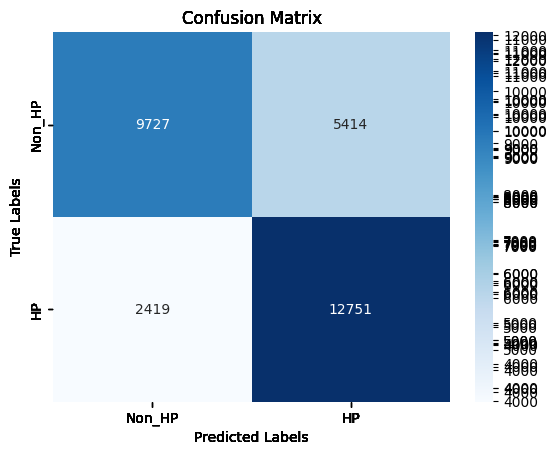

In [33]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='GitHub_high_vs_rest', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [34]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [35]:
test_df = test_hp_df

In [36]:
test_df

,label,text
18675,1,opening a users profile leaves riot unresponsi...
59263,1,nnbd dart does not throw a compile error when ...
68623,0,internal server error during the password reco...
16484,0,hero flows multiple intents leaves some render...
27086,1,missing nullable missing new nullable compiler...
...,...,...
54886,1,che deployment on crc fails i have used latest...
76820,0,amp by automattic compatibility amp by automat...
103694,0,aws sg deletion failure and causing throttling...
860,1,add gf check for metadata subsets with zero su...


In [37]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [38]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [39]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [40]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [41]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 1003/1003 [02:47<00:00,  5.99it/s]


Fold 1


100%|██████████| 1003/1003 [02:47<00:00,  6.00it/s]


Fold 2


100%|██████████| 1003/1003 [02:47<00:00,  6.00it/s]


In [42]:
deberta_predictions


[array([[0.03908475, 0.9609153 ],
        [0.96972704, 0.03027301],
        [0.4411192 , 0.55888075],
        ...,
        [0.88152826, 0.11847177],
        [0.02531014, 0.9746899 ],
        [0.11014965, 0.8898504 ]], dtype=float32),
 array([[0.11367507, 0.88632494],
        [0.94690853, 0.05309144],
        [0.8333297 , 0.16667038],
        ...,
        [0.9127217 , 0.08727831],
        [0.19650665, 0.8034934 ],
        [0.25295615, 0.7470439 ]], dtype=float32),
 array([[0.33911952, 0.6608805 ],
        [0.93440866, 0.06559134],
        [0.6770642 , 0.32293582],
        ...,
        [0.9199058 , 0.08009423],
        [0.21355593, 0.78644407],
        [0.3031609 , 0.69683915]], dtype=float32)]

In [43]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.16395979, 0.83604026],
       [0.9503481 , 0.04965193],
       [0.65050435, 0.34949565],
       ...,
       [0.9047186 , 0.09528143],
       [0.14512424, 0.85487574],
       [0.22208889, 0.7779111 ]], dtype=float32)

In [44]:
len(predictions)

16047

In [45]:
predictions

array([[0.16395979, 0.83604026],
       [0.9503481 , 0.04965193],
       [0.65050435, 0.34949565],
       ...,
       [0.9047186 , 0.09528143],
       [0.14512424, 0.85487574],
       [0.22208889, 0.7779111 ]], dtype=float32)

In [46]:
test_df["prediction_0"] = predictions[:, 0] 

In [47]:
test_df["prediction_1"] = predictions[:, 1] 

In [48]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [49]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
18675,1,opening a users profile leaves riot unresponsi...,0.163960,0.836040,1,1,1
59263,1,nnbd dart does not throw a compile error when ...,0.950348,0.049652,0,0,0
68623,0,internal server error during the password reco...,0.650504,0.349496,1,0,0
16484,0,hero flows multiple intents leaves some render...,0.852906,0.147094,0,0,0
27086,1,missing nullable missing new nullable compiler...,0.549828,0.450172,0,0,1
...,...,...,...,...,...,...,...
54886,1,che deployment on crc fails i have used latest...,0.468577,0.531423,0,1,1
76820,0,amp by automattic compatibility amp by automat...,0.098556,0.901444,1,1,1
103694,0,aws sg deletion failure and causing throttling...,0.904719,0.095281,0,0,0
860,1,add gf check for metadata subsets with zero su...,0.145124,0.854876,1,1,1


In [50]:
len(test_df)

16047

In [51]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [52]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [53]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [54]:
test_df["pred"] = test_df["pred"].astype(int)

In [55]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
18675,1,opening a users profile leaves riot unresponsi...,0.163960,0.836040,1,1,1,prediction_1,1
59263,1,nnbd dart does not throw a compile error when ...,0.950348,0.049652,0,0,0,prediction_0,0
68623,0,internal server error during the password reco...,0.650504,0.349496,1,0,0,prediction_0,0
16484,0,hero flows multiple intents leaves some render...,0.852906,0.147094,0,0,0,prediction_0,0
27086,1,missing nullable missing new nullable compiler...,0.549828,0.450172,0,0,1,prediction_0,0
...,...,...,...,...,...,...,...,...,...
54886,1,che deployment on crc fails i have used latest...,0.468577,0.531423,0,1,1,prediction_1,1
76820,0,amp by automattic compatibility amp by automat...,0.098556,0.901444,1,1,1,prediction_1,1
103694,0,aws sg deletion failure and causing throttling...,0.904719,0.095281,0,0,0,prediction_0,0
860,1,add gf check for metadata subsets with zero su...,0.145124,0.854876,1,1,1,prediction_1,1


In [56]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[6249 1758]
 [2135 5905]]


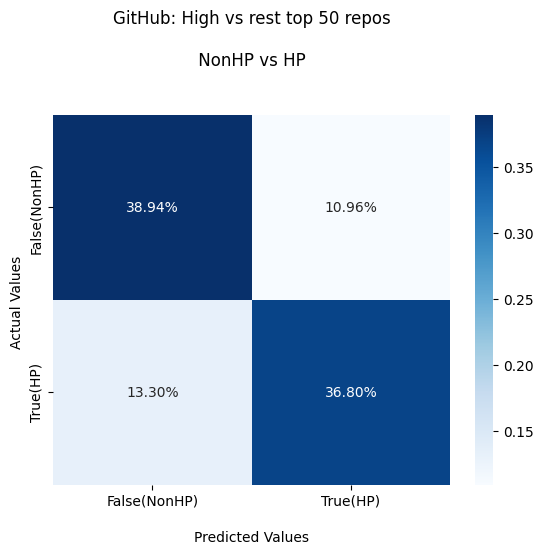

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: High vs rest top 50 repos\n\n NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [58]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      8007
           1       0.77      0.73      0.75      8040

    accuracy                           0.76     16047
   macro avg       0.76      0.76      0.76     16047
weighted avg       0.76      0.76      0.76     16047



In [59]:
tracker.stop()

0.060801635997563476